In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
import os
import glob
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.cm as cm

import math
import pandas as pd
from pandas import DataFrame, read_csv
import pylab as pl

In [2]:
""" 
Little helper function to load data from a .trc binary file.
This is the file format used by LeCroy oscilloscopes.
M. Betz 09/2015
"""
import datetime
import numpy as np
import struct

def readTrc( fName ):
    """
        Reads .trc binary files from LeCroy Oscilloscopes.
        Decoding is based on LECROY_2_3 template.
        [More info](http://forums.ni.com/attachments/ni/60/4652/2/LeCroyWaveformTemplate_2_3.pdf)
        
        Parameters
        -----------       
        fName = filename of the .trc file
        
        Returns
        -----------       
        x: array with sample times [s],
        
        y: array with sample  values [V],
        
        d: dictionary with metadata
        
        
        M. Betz 09/2015
    """
    with open(fName, "rb") as fid:
        data = fid.read(50).decode()
        wdOffset = data.find('WAVEDESC')
        
        #------------------------
        # Get binary format / endianess
        #------------------------
        if readX( fid, '?', wdOffset + 32 ):  #16 or 8 bit sample format?
            smplFmt = "int16"
        else:
            smplFmt = "int8"
        if readX( fid, '?', wdOffset + 34 ):  #Big or little endian?
            endi = "<"
        else:
            endi = ">"
            
        #------------------------
        # Get length of blocks and arrays:
        #------------------------
        lWAVE_DESCRIPTOR = readX( fid, endi+"l", wdOffset + 36 )
        lUSER_TEXT       = readX( fid, endi+"l", wdOffset + 40 )
        lTRIGTIME_ARRAY  = readX( fid, endi+"l", wdOffset + 48 )
        lRIS_TIME_ARRAY  = readX( fid, endi+"l", wdOffset + 52 )
        lWAVE_ARRAY_1    = readX( fid, endi+"l", wdOffset + 60 )
        lWAVE_ARRAY_2    = readX( fid, endi+"l", wdOffset + 64 )

        d = dict()  #Will store all the extracted Metadata
        
        #------------------------
        # Get Instrument info
        #------------------------
        d["INSTRUMENT_NAME"]  = readX( fid, "16s",    wdOffset + 76 ).decode().split('\x00')[0]
        d["INSTRUMENT_NUMBER"]= readX( fid, endi+"l", wdOffset + 92 )
        d["TRACE_LABEL"]      = readX( fid, "16s",    wdOffset + 96 ).decode().split('\x00')[0]
        
        #------------------------
        # Get Waveform info      
        #------------------------
        d["WAVE_ARRAY_COUNT"] = readX( fid, endi+"l", wdOffset +116 )
        d["PNTS_PER_SCREEN"]  = readX( fid, endi+"l", wdOffset +120 )
        d["FIRST_VALID_PNT"]  = readX( fid, endi+"l", wdOffset +124 )
        d["LAST_VALID_PNT"]   = readX( fid, endi+"l", wdOffset +128 )
        d["FIRST_POINT"]      = readX( fid, endi+"l", wdOffset +132 )
        d["SPARSING_FACTOR"]  = readX( fid, endi+"l", wdOffset +136 )
        d["SEGMENT_INDEX"]    = readX( fid, endi+"l", wdOffset +140 )
        d["SUBARRAY_COUNT"]   = readX( fid, endi+"l", wdOffset +144 )
        d["SWEEPS_PER_ACQ"]   = readX( fid, endi+"l", wdOffset +148 )
        d["POINTS_PER_PAIR"]  = readX( fid, endi+"h", wdOffset +152 )
        d["PAIR_OFFSET"]      = readX( fid, endi+"h", wdOffset +154 )
        d["VERTICAL_GAIN"]    = readX( fid, endi+"f", wdOffset +156 ) #to get floating values from raw data :
        d["VERTICAL_OFFSET"]  = readX( fid, endi+"f", wdOffset +160 ) #VERTICAL_GAIN * data - VERTICAL_OFFSET 
        d["MAX_VALUE"]        = readX( fid, endi+"f", wdOffset +164 )
        d["MIN_VALUE"]        = readX( fid, endi+"f", wdOffset +168 )
        d["NOMINAL_BITS"]     = readX( fid, endi+"h", wdOffset +172 )
        d["NOM_SUBARRAY_COUNT"]= readX( fid, endi+"h",wdOffset +174 )
        d["HORIZ_INTERVAL"]   = readX( fid, endi+"f", wdOffset +176 ) #sampling interval for time domain waveforms 
        d["HORIZ_OFFSET"]     = readX( fid, endi+"d", wdOffset +180 ) #trigger offset for the first sweep of the trigger, seconds between the trigger and the first data point 
        d["PIXEL_OFFSET"]     = readX( fid, endi+"d", wdOffset +188 )
        d["VERTUNIT"]         = readX( fid, "48s", wdOffset +196 ).decode().split('\x00')[0]
        d["HORUNIT"]          = readX( fid, "48s", wdOffset +244 ).decode().split('\x00')[0]
        d["HORIZ_UNCERTAINTY"]= readX( fid, endi+"f", wdOffset +292 )
        d["TRIGGER_TIME"]     = getTimeStamp( fid, endi, wdOffset +296 )
        d["ACQ_DURATION"]     = readX( fid, endi+"f", wdOffset +312 )
        d["RECORD_TYPE"]      = ["single_sweep","interleaved","histogram","graph","filter_coefficient","complex","extrema","sequence_obsolete","centered_RIS","peak_detect"][ readX( fid, endi+"H", wdOffset +316 ) ]
        d["PROCESSING_DONE"]  = ["no_processing","fir_filter","interpolated","sparsed","autoscaled","no_result","rolling","cumulative"][ readX( fid, endi+"H", wdOffset +318 ) ]
        d["RIS_SWEEPS"]       = readX( fid, endi+"h", wdOffset +322 )
        d["TIMEBASE"]         = ['1_ps/div', '2_ps/div', '5_ps/div', '10_ps/div', '20_ps/div', '50_ps/div', '100_ps/div', '200_ps/div', '500_ps/div', '1_ns/div', '2_ns/div', '5_ns/div', '10_ns/div', '20_ns/div', '50_ns/div', '100_ns/div', '200_ns/div', '500_ns/div', '1_us/div', '2_us/div', '5_us/div', '10_us/div', '20_us/div', '50_us/div', '100_us/div', '200_us/div', '500_us/div', '1_ms/div', '2_ms/div', '5_ms/div', '10_ms/div', '20_ms/div', '50_ms/div', '100_ms/div', '200_ms/div', '500_ms/div', '1_s/div', '2_s/div', '5_s/div', '10_s/div', '20_s/div', '50_s/div', '100_s/div', '200_s/div', '500_s/div', '1_ks/div', '2_ks/div', '5_ks/div', 'EXTERNAL'][ readX( fid, endi+"H", wdOffset +324 ) ]
        d["VERT_COUPLING"]    = ['DC_50_Ohms', 'ground', 'DC_1MOhm', 'ground', 'AC,_1MOhm'][ readX( fid, endi+"H", wdOffset +326 ) ]
        d["PROBE_ATT"]        = readX( fid, endi+"f", wdOffset +328 )
        d["FIXED_VERT_GAIN"]  = ['1_uV/div','2_uV/div','5_uV/div','10_uV/div','20_uV/div','50_uV/div','100_uV/div','200_uV/div','500_uV/div','1_mV/div','2_mV/div','5_mV/div','10_mV/div','20_mV/div','50_mV/div','100_mV/div','200_mV/div','500_mV/div','1_V/div','2_V/div','5_V/div','10_V/div','20_V/div','50_V/div','100_V/div','200_V/div','500_V/div','1_kV/div'][ readX( fid, endi+"H", wdOffset +332 ) ]
        d["BANDWIDTH_LIMIT"]  = ['off', 'on'][ readX( fid, endi+"H", wdOffset +334 ) ]
        d["VERTICAL_VERNIER"] = readX( fid, endi+"f", wdOffset +336 )
        d["ACQ_VERT_OFFSET"]  = readX( fid, endi+"f", wdOffset +340 )
        d["WAVE_SOURCE"]      = readX( fid, endi+"H", wdOffset +344 )
        d["USER_TEXT"]        = readX( fid, "{0}s".format(lUSER_TEXT), wdOffset + lWAVE_DESCRIPTOR ).decode().split('\x00')[0]

        #------------------------
        # Get main sample data with the help of numpys .fromfile(
        #------------------------
        fid.seek( wdOffset + lWAVE_DESCRIPTOR + lUSER_TEXT + lTRIGTIME_ARRAY + lRIS_TIME_ARRAY ) #Seek to WAVE_ARRAY_1
        y = np.fromfile( fid, smplFmt, lWAVE_ARRAY_1 )
        if endi == ">":
            y.byteswap( True )
        y = d["VERTICAL_GAIN"] * y - d["VERTICAL_OFFSET"]
        x = np.arange(1,len(y)+1)*d["HORIZ_INTERVAL"] + d["HORIZ_OFFSET"]
    return x, y, d

def readX( fid, fmt, adr=None ):
    """ extract a byte / word / float / double from the binary file """
    nBytes = struct.calcsize( fmt )
    if adr is not None:
        fid.seek( adr )
    s = struct.unpack( fmt, fid.read( nBytes ) )
    if(type(s) == tuple):
        return s[0]
    else:
        return s

def getTimeStamp( fid, endi, adr ):
    """ extract a timestamp from the binary file """
    s = readX( fid, endi+"d", adr )
    m = readX( fid, endi+"b" )
    h = readX( fid, endi+"b" )
    D = readX( fid, endi+"b" )
    M = readX( fid, endi+"b" )
    Y = readX( fid, endi+"h" )
    trigTs = datetime.datetime(Y, M, D, h, m, int(s), int((s-int(s))*1e6) )
    return trigTs

In [3]:
cd /Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long

/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long


In [4]:
os.listdir()

['.DS_Store',
 '0000',
 '0500',
 '1000',
 '1500',
 '2000',
 '2500',
 '3000',
 '3500',
 '4000']

In [5]:
Folders=os.listdir()
Folders = Folders[1:len(Folders)]
Folders

['0000', '0500', '1000', '1500', '2000', '2500', '3000', '3500', '4000']

In [9]:
#Folders=os.listdir()
pathM= "/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long"
paths=dict()
for f in range(0,len(Folders)):
    paths[f] = pathM +"/"+Folders[f]

In [10]:
paths

{0: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/0000',
 1: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/0500',
 2: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/1000',
 3: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/1500',
 4: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/2000',
 5: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/2500',
 6: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/3000',
 7: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/3500',
 8: '/Users/austinmcdonald/Desktop/data/IonDrift_5-24-17-Long/4000'}

In [12]:
#%%time
dataX=[]
dataY=[]
XTraces=dict()
YTraces=dict()
volt = dict()
time = dict()
for z in range(0,len(paths)):
    dataX=[]
    dataY=[]
    Files = os.listdir(paths[z])
    for x in range(0,len(Files)):
        datX, datY, info = readTrc(paths[z]+"/"+Files[x])
        NTraces     =   info['SUBARRAY_COUNT']
        TotalPoints =   info[ 'WAVE_ARRAY_COUNT']
        dx          =   info['HORIZ_INTERVAL']
        PPT         =   TotalPoints/NTraces
        YTraces[x]   =   np.split(datY, NTraces)
        XTraces[x]   =   np.split(datX, NTraces)
        for y in range(0,len(YTraces[x])):
            dataX.append(XTraces[x][y])
            dataY.append(YTraces[x][y])
    volt[z] = np.array(dataY)
    time[z] = np.array(dataX)

In [13]:
volt[1][1]

array([-0.000625  , -0.00072917, -0.00072917, ..., -0.00072917,
       -0.0009375 , -0.00052083])

In [14]:
Efield=[]
Volt = dict()
STD  = dict()
Time = dict()
for x in range(0,len(paths)):
    Volt[x] = np.mean(volt[x],axis=0)
    STD[x] = np.std(volt[x],axis=0)
    Time[x] = time[x][0]
    Efield.append(float(Folders[x])/20)

In [15]:
Efield

[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0]

In [31]:
mu = 1e6
ml = 1e3
unit=  r"$\frac{V}{cm}$"
plt.figure(figsize=(15,9))
for x in range(0,len(paths)):
    plt.plot(savgol_filter(Time[x],11,3)*ml,savgol_filter(Volt[x],11,3)*ml,label=str(Efield[x]) + unit,color=cm.afmhot((x+2)/25))
#plt.text(325, -10, r'750 Torr', fontsize=30)
#plt.text(25, -1.5, r'RC=1s', fontsize=30)
plt.title('BTX ION drift 5-24-17 ',fontsize=30)
plt.xlim(-10,185)
plt.ylim(-0.8,0)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltaeg / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_ION_5-18-17-2.pdf')

plt.show()

KeyError: 0

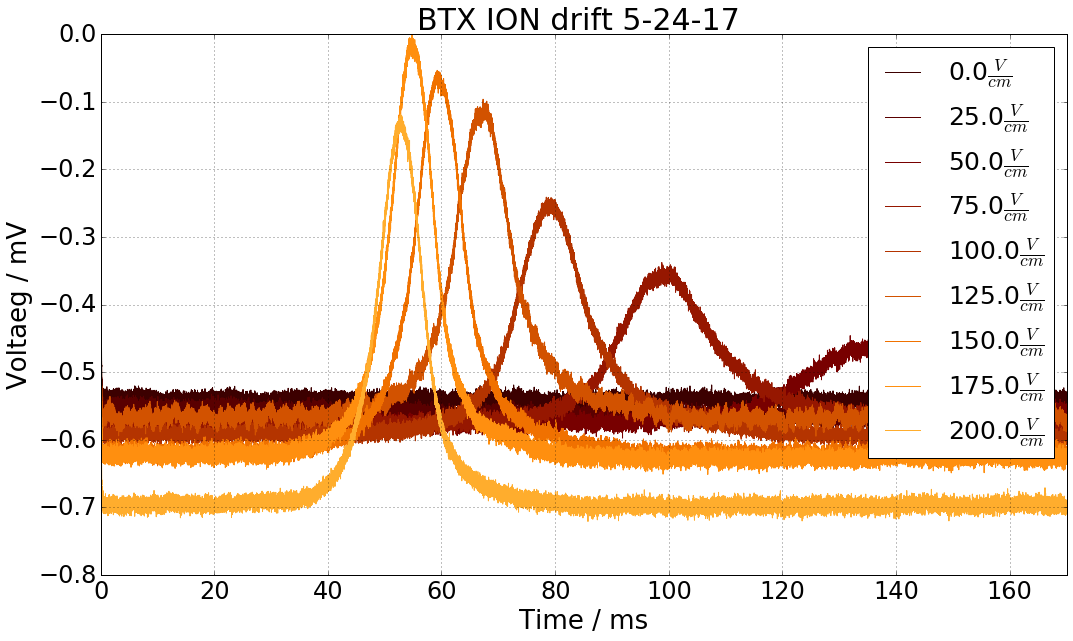

In [37]:
mu = 1e6
ml = 1e3
unit=  r"$\frac{V}{cm}$"
plt.figure(figsize=(15,9))
for x in range(0,len(paths)):
    plt.plot(Time[x]*ml,Volt[x]*ml,label=str(Efield[x]) + unit,color=cm.afmhot((x+2)/17))

#plt.text(325, -10, r'750 Torr', fontsize=30)
#plt.text(25, 10, r'RC=10$\mu$s', fontsize=30)
plt.title('BTX ION drift 5-24-17 ',fontsize=30)
plt.xlim(0,170)
plt.ylim(-0.8,0)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltaeg / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=25)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_ION_5-18-17-2.pdf')

plt.show()

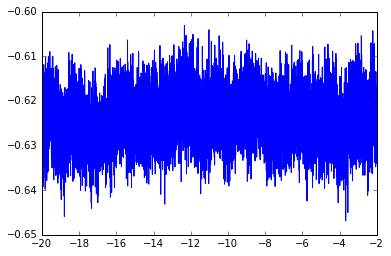

In [18]:
aa=9000
plt.plot(Time[7][0:aa]*ml,Volt[7][0:aa]*ml)

In [65]:
np.mean(Volt[7][0:aa]*ml)

-0.62402397886113292

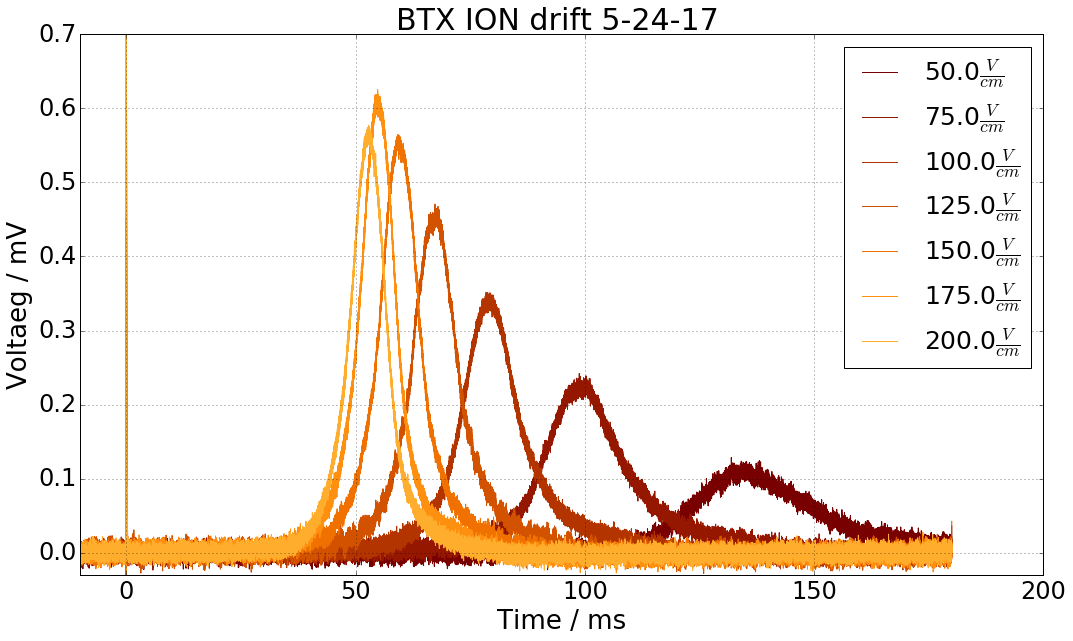

In [38]:
mu = 1e6
ml = 1e3
unit=  r"$\frac{V}{cm}$"
plt.figure(figsize=(15,9))
for x in range(2,len(paths)):
    plt.plot(Time[x]*ml,(Volt[x]+abs(np.mean(Volt[x][0:9000])))*ml,label=str(Efield[x]) + unit,color=cm.afmhot((x+2)/17))
#plt.text(325, -10, r'750 Torr', fontsize=30)
#plt.text(25, 10, r'RC=10$\mu$s', fontsize=30)
plt.title('BTX ION drift 5-24-17 ',fontsize=30)
plt.xlim(-10,200)
plt.ylim(-.03,0.7)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltaeg / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=25)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_ION_5-24-17-2.pdf')

plt.show()

In [35]:
Fdata = []
Ftime = []
for x in range(2,len(paths)):
    Fdata.append(((Volt[x]+abs(np.mean(Volt[x][0:9000])))*ml)[12000:])
    Ftime.append((Time[x]*ml)[12000:])

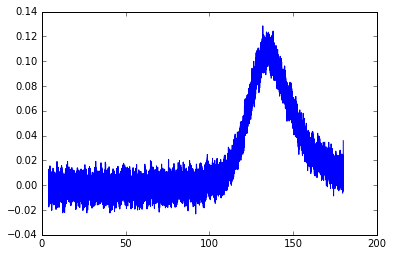

In [77]:
for x in range(0,1):
    plt.plot(Ftime[x],Fdata[x])

In [49]:
MeanLoc = np.where(Fdata[0]==max(Fdata[0]))[0][0]
Mean = Ftime[0][aa]

131.93447988286135

In [74]:
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_fit_vals(dataX,dataY):
    maxx = max(dataY)
    sig_val = maxx*0.5
    MeanLoc = np.where(dataY==max(dataY))[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    sigma_point = (Rpoint-Lpoint)/2   
    return (Mean,sigma_point)

In [78]:
FitVals = []
for q in range(0,len(paths)-2):
    x = Ftime[q]
    y = Fdata[q]
    aa = find_fit_vals(x,y)
    popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), aa[0], aa[1]])
    FitVals.append(popt)
    

In [93]:
FitVals

array([[  1.02169435e-01,   1.36833779e+02,   1.35609593e+01],
       [  2.09175177e-01,   9.98620618e+01,   9.35694665e+00],
       [  3.15682822e-01,   7.95134498e+01,   6.85675599e+00],
       [  4.25351402e-01,   6.73476157e+01,   5.55206471e+00],
       [  5.22047152e-01,   5.95819326e+01,   4.80302609e+00],
       [  5.76024891e-01,   5.48231097e+01,   4.25862741e+00],
       [  5.36881976e-01,   5.27329376e+01,   4.21375492e+00]])

In [96]:
FitVals=np.array(FitVals)
FitVals[:,2]

array([ 13.56095928,   9.35694665,   6.85675599,   5.55206471,
         4.80302609,   4.25862741,   4.21375492])

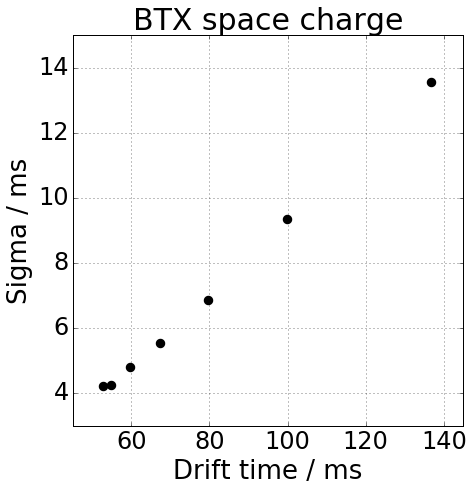

In [118]:
plt.figure(figsize=(7,7))
plt.scatter(FitVals[:,1],FitVals[:,2],linewidth=5)
plt.title('BTX space charge',fontsize=30)
plt.xlim(45,145)
plt.ylim(3,15)
plt.xlabel(r'Drift time / ms',fontsize=26)
plt.ylabel('Sigma / ms',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
#plt.savefig('/Users/austinmcdonald/Desktop/BTX_spacecharge.pdf')

plt.show()

In [106]:
vel = 200/FitVals[:,1]

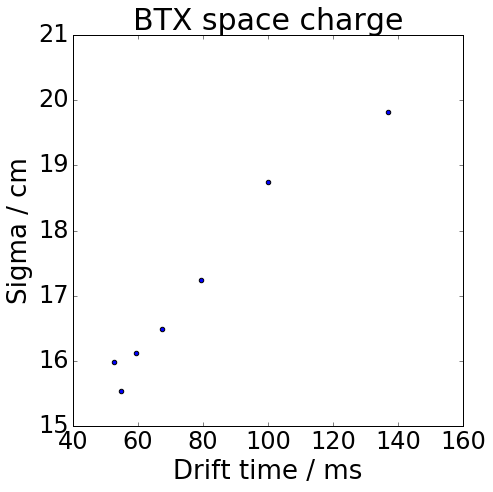

In [109]:
plt.figure(figsize=(7,7))
plt.scatter(FitVals[:,1],FitVals[:,2]*200/FitVals[:,1])
plt.title('BTX space charge',fontsize=30)
#plt.xlim(50,150)
#plt.ylim(3,15)
plt.xlabel(r'Drift time / ms',fontsize=26)
plt.ylabel('Sigma / cm',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [143]:
dx = Time[0][2]-Time[0][1]
area=[]
areae=[]
areaE=[]
Efield=[]
Nele  =[]
for x in range(2,len(paths)):
    area.append( np.sum(abs((Volt[x][cut:]+abs(np.mean(Volt[x][0:9000])))*ml))*dx)
    areae.append(np.sqrt(sum(STD[x]**2)))
    Efield.append(float(Folders[x])/20)
#    Nele.append(((area[x]*10e-12)/1.6e-19)/1e9)
#    areaE.append(((areae[x]*10e-12)/1.6e-19)/1e9)

In [139]:
area

[0.0039650146772323858,
 0.0057575606147240149,
 0.0064642024166118583,
 0.0071632137704186923,
 0.0075056830559302413,
 0.0073863666185291464,
 0.0066974734300097628]

In [144]:
areae

[0.078775427683226873,
 0.071865541589694812,
 0.071558520728715644,
 0.081619432121725149,
 0.070829458704541284,
 0.068948038760692859,
 0.072877617578824119]

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(Efield,Nele,linewidth=3)
plt.title('BTX number of electrons ',fontsize=30)
plt.xlim(-5,205)
#plt.ylim(0,500)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel('billions of electrons ',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

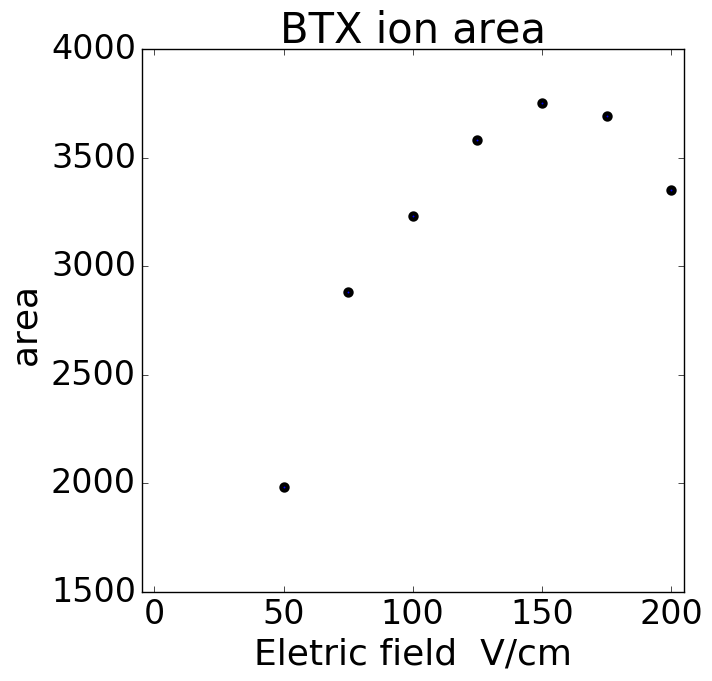

In [128]:
plt.figure(figsize=(7,7))
plt.scatter(Efield,area,linewidth=3)
plt.title('BTX ion area',fontsize=30)
plt.xlim(-5,205)
#plt.ylim(0,250)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel('area ',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [130]:
#cut =100000
arrival=[]
velocity=[]
for x in range(2,len(paths)):
    mins=max(Volt[x][cut:])
    arrival.append( Time[x][cut:][np.where(Volt[x][cut:]==mins)[0][0]]*ml)
    velocity.append(200/ (Time[x][cut:][np.where(Volt[x][cut:]==mins)[0][0]]*ml))


In [131]:
arrival

[131.93447988286135,
 98.77537039271445,
 78.445782736841579,
 67.319608785422005,
 59.239531534849547,
 54.812206763841473,
 52.820292415195958]

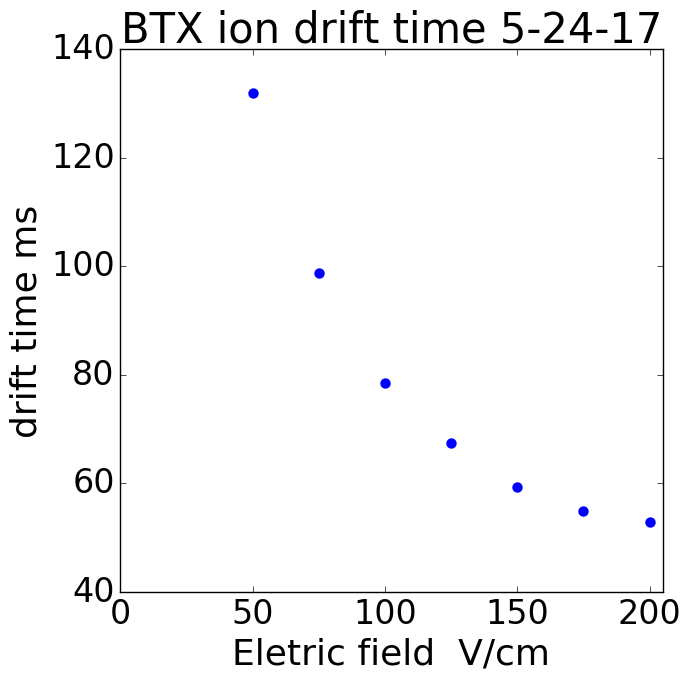

In [97]:
plt.figure(figsize=(7,7))
plt.scatter(Efield[2:9],arrival[2:9],linewidth=3,color='b')
plt.title('BTX ion drift time 5-24-17',fontsize=30)
plt.xlim(0,205)
#plt.ylim(90,140)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel(r'drift time ms',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig('BTX_ION_drift_TIME_5-24-17-2.pdf')

plt.show()

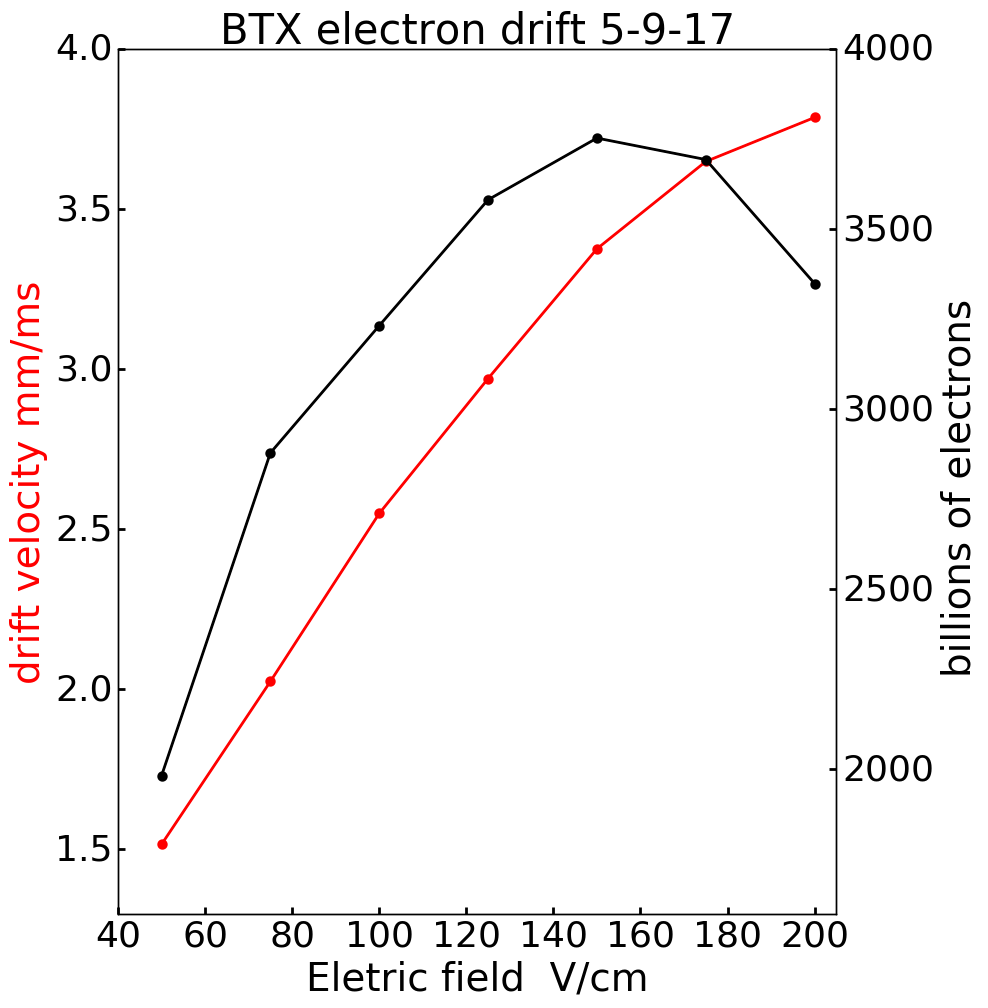

In [137]:

x = Efield
y1 = velocity
y2 = area
xerr = 0
y1err =.0
y2err = 0


fig, ax1 = plt.subplots(figsize=(10,10))

ax2 = ax1.twinx()
ax1.plot(x,y1,color='r',linewidth=2)
ax1.scatter(x, y1,color='r',lw=3)
ax1.errorbar(x, y1, yerr=y1err,color='r')
ax2.scatter(x, y2,color='k',lw=3)
ax2.plot(x,y2,color='k',linewidth=2)
ax2.errorbar(x, y2, yerr=y2err,color='k')

ax1.set_xlabel(r'Eletric field  V/cm',fontsize=28)
ax1.set_ylabel(r'drift velocity mm/ms', color='r',fontsize=28)
ax1.set_ylim([1.3,4])
ax2.set_ylim([1600,4000])

ax2.set_ylabel('billions of electrons ', color='k',fontsize=28)

ax1.xaxis.set_tick_params(labelsize=26)
ax2.yaxis.set_tick_params(labelsize=26)
ax1.yaxis.set_tick_params(labelsize=26)
ax1.tick_params(axis='y',width=2,length=5)
ax2.tick_params(axis='y',width=2,length=5)
ax1.tick_params(axis='x',width=2,length=5)
ax1.tick_params(top="off")

#plt.suptitle('Fluorescein Buffer&PH Dependence',size= 22)
plt.tight_layout()
plt.title('BTX electron drift 5-9-17',fontsize=30)

plt.xlim(40,205)
#plt.savefig('BTX_electron_drift_ana_5-9-17.pdf')
plt.show()



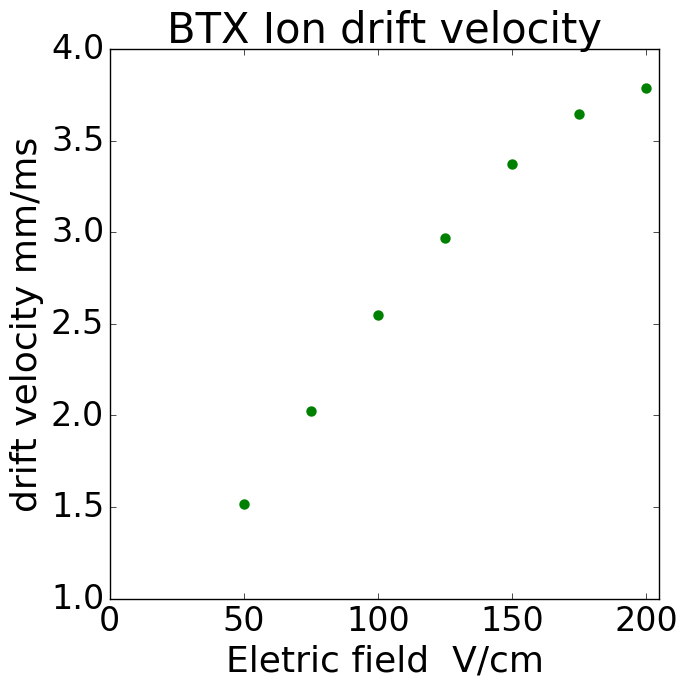

In [121]:
plt.figure(figsize=(7,7))
plt.scatter(Efield,velocity,linewidth=3,color='g')
plt.title('BTX Ion drift velocity',fontsize=30)
plt.xlim(0,205)
#plt.ylim(90,140)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel(r'drift velocity mm/ms',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_velocity_5-24-17-2.pdf')

plt.show()

52.8202924152


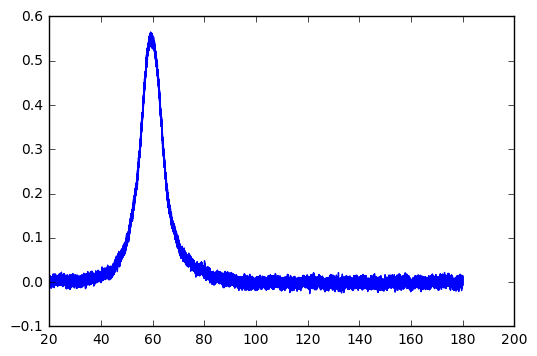

In [148]:
plt.plot(Time[6][cut:]*ml,(Volt[6][cut:]+abs(np.mean(Volt[6][0:9000])))*ml)
print(arrival[6])

[  0.52204879  59.58193131   4.80299586]


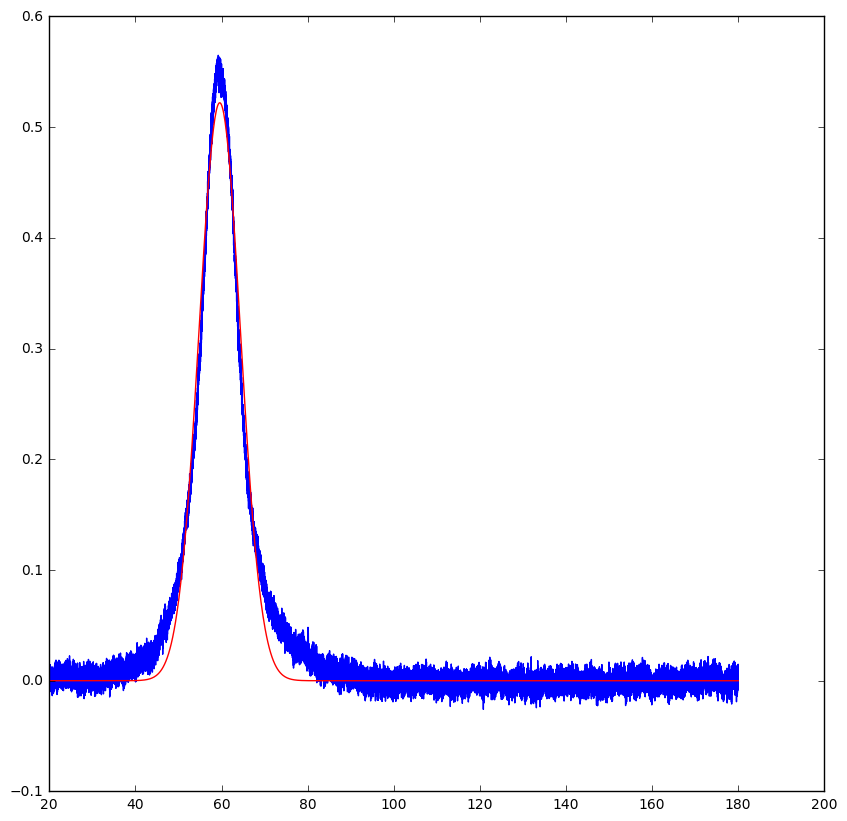

In [153]:
#Fit to normal gaussian

#xcut = 140
##ycut = 175
#binc = bin_centres[xcut:ycut]
#backg = bg1[xcut:ycut]
#hist21 = nobg1[xcut:ycut]
#hist2 = areas[xcut:ycut]
x = Time[6][cut:]*ml
y1 = (Volt[6][cut:]+abs(np.mean(Volt[6][0:9000])))*ml



def gauss(x, *p):                                               #defines gaussian fit
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

                                                                #prediction of mean from array
#mean=float(sum(areas))/len(areas) if len(areas) > 0 else float('nan')  
mean1 = arrival[6]
SD1   = 40

p0 = [0.55, mean1, SD1]                                             #estimation of parameters
coeff, var_matrix = curve_fit(gauss, x, y1, p0=p0)               #fits the gauss function to the data

dof = len(y1)-len(coeff)

plt.figure(figsize=(10,10))
plt.plot(x,y1)
fitarray = []
for u in range(0,len(x)-1):
    fitarray.append(((x[u+1]-x[u])/2)+x[u])

vars=np.linspace(fitarray[0],fitarray[-1],1000)              #draws the fit
hist_fit = gauss(vars, *coeff)
plt.plot(vars, hist_fit, label='Fitted data', color= "Red")
#plt.ylim(0,500)
#plt.plot(x,backg)
print(coeff)
plt.show()

In [ ]:
areaP = []
for x in range(0,len(paths)):
    areaP.append((area[x]/area[len(paths)-1])*100)

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(Efield,areaP,linewidth=3)
plt.title('BTX electron percent',fontsize=30)
plt.xlim(-5,205)
plt.ylim(0,105)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel('percent area ',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [ ]:
(area[8]*10)/1.6

In [ ]:
vd = []
for x in range(0,len(paths)):
    vd.append(areaP[x]*velocity[x])

In [ ]:
plt.figure(figsize=(7,7))
#plt.scatter(arrival,areaP,linewidth=3)
#plt.plot(x,func(x,*popt),color='r')
plt.plot(x,10*np.exp(-x/0.0596754))
#plt.title('BTX electron loss',fontsize=30)
#plt.xlim(90,140)
#plt.ylim(0,110)
plt.xlabel('drift time ',fontsize=26)
plt.ylabel(r'area ratio',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.show()

In [ ]:
arrival

In [ ]:
areaPP = []
for x in range(0,len(paths)):
    areaPP.append((area[x]/area[len(paths)-1]))

In [ ]:
from scipy.optimize import curve_fit

def func(x, c):
    return np.exp(-x/c)

popt, pcov = curve_fit(func, arrival, areaPP, p0 = ( 500))
print( popt)

plt.plot(arrival,areaPP)
x=np.linspace(0,150)
plt.plot(x,func(x,*popt),color='r')
#plt.ylim(0,1)
plt.show()

In [ ]:
lna=np.log(areaPP)

In [ ]:
lna

In [ ]:
np.polyfit(arrival,lna, 1)

In [ ]:
x=np.linspace(0,150)
plt.plot(x,-0.0596754*x+5.55655925)
plt.plot(arrival,lna)


In [ ]:
np.polyfit(arrival,np.log(areaPP), 1)

In [ ]:
x

In [ ]:
a= np.linspace(0,150)

In [ ]:
a